# 프로젝트 목차   
## 1. Sentence Piece-unigram로 토큰화 후 시도   
   
   
### 1) 데이터 로드   
### 2) 전처리   
### 3) 토크나이즈   
### 4) 문장 길이 고정   
### 5) 최종 데이터 셋 확인
### 6) 모델 설계
### 7) 모델 훈련   
### 8) 훈련 결과 시각화   
### 9) 모델 테스트   
   
   
## 2. Sentence Piece-BPE 로 토크나이즈 후 재시도    
## 3. Mecab기반 토큰화 후 재시도   
   
## 4. 회고


In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from collections import Counter
import sentencepiece as spm
from konlpy.tag import Mecab

from tensorflow import keras
from tensorflow.keras.models import load_model

# 1. Sentence Piece-unigram 으로 토큰화 후 시도

## 1) 네이버 영화리뷰 데이터 로드

In [2]:
train_data = pd.read_table('~/mini_projects/_E-04_NLP1/ratings_train.txt')
test_data = pd.read_table('~/mini_projects/_E-04_NLP1/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


## 2) 전처리 

### 중복 데이터 및 결측치 제거

In [5]:
len(train_data), len(test_data)

(150000, 50000)

In [6]:
train_data.drop_duplicates(subset=['document'], inplace=True)
test_data.drop_duplicates(subset=['document'], inplace=True)

train_data = train_data.dropna(how = 'any')
test_data = test_data.dropna(how = 'any')

In [7]:
len(train_data),len(test_data)

(146182, 49157)

## 3) 토크나이즈(Sentence Piece-unigram)

In [9]:
vocab_size = 8000

review_file = os.getenv('HOME')+'/mini_projects/_G-01_tokenize/movie_review.txt'

with open(review_file, 'w') as f:
    for row in train_data['document']: 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=movie_review --vocab_size={}'.format(review_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

s = spm.SentencePieceProcessor()
s.Load('movie_review.model')

def sp_tokenize(s, train_corpus, test_corpus):

    train_tensor = []
    test_tensor = []

    for sen in train_corpus:
        train_tensor.append(s.EncodeAsIds(sen))
        
    for sen in test_corpus:
        test_tensor.append(s.EncodeAsIds(sen))

    with open("./movie_review.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return train_tensor, test_tensor, word_index, index_word

train_tensor, test_tensor, word_index, index_word = sp_tokenize(s, train_data['document'], test_data['document'])

In [10]:
len(train_tensor), len(test_tensor), len(word_index), len(index_word)

(146182, 49157, 8000, 8000)

In [11]:
train_tensor[0]

[64, 879, 5, 31, 2190, 65, 1853]

In [12]:
print(s.DecodeIds(train_tensor[0]))

아 더빙.. 진짜 짜증나네요 목소리


## 4) 문장길이 고정

### 데이터셋 문장길이 확인

훈련셋 문장의 최단 길이: 1
훈련셋 문장의 최장 길이: 134
훈련셋 문장의 평균 길이: 17


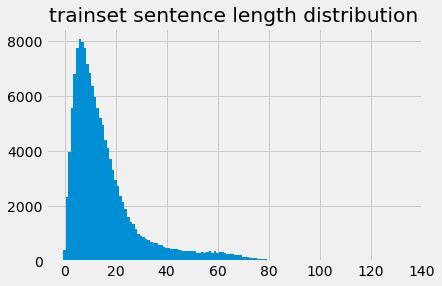

In [13]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("훈련셋 문장의 최단 길이:", min_len)
print("훈련셋 문장의 최장 길이:", max_len)
print("훈련셋 문장의 평균 길이:", sum_len // len(train_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("trainset sentence length distribution")
plt.show()

테스트셋 문장의 최단 길이: 1
테스트셋 문장의 최장 길이: 118
테스트셋 문장의 평균 길이: 17


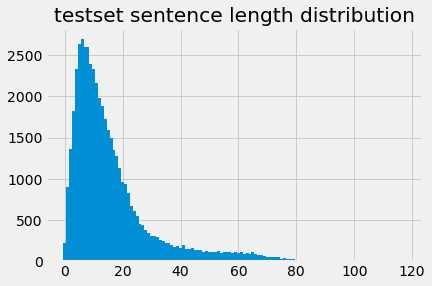

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in test_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("테스트셋 문장의 최단 길이:", min_len)
print("테스트셋 문장의 최장 길이:", max_len)
print("테스트셋 문장의 평균 길이:", sum_len // len(test_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in test_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("testset sentence length distribution")
plt.show()

### 문장길이 통일 및 패딩

In [15]:
maxlen = 20
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post', maxlen = maxlen)

In [28]:
x = X_train[0].tolist()

In [29]:
print(s.DecodeIds(x))

아 더빙.. 진짜 짜증나네요 목소리 ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 


## 5) 최종 데이터셋 확인

In [16]:
Y_train = np.array(list(train_data['label']))
Y_test =  np.array(list(test_data['label']))

In [17]:
len(X_train), len(X_test), len(Y_train), len(Y_test)

(146182, 49157, 146182, 49157)

## 6) LSTM 모델 설계

In [29]:
#  LSTM으로 학습
model = keras.Sequential([
    keras.layers.Embedding(8000, 100),# (Size of the vocabulary, Dimension of the dense embedding)
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## 7) 모델 훈련

In [34]:
history = model.fit(X_train, Y_train, epochs=100, callbacks=[early_stopping, model_checkpoint], 
                   batch_size=32 ,validation_split=0.2
                   )

Epoch 1/100
3655/3655 [==============================] - ETA: 0s - loss: 0.4012 - acc: 0.8166
Epoch 00001: val_acc improved from -inf to 0.84732, saving model to best_model.h5
3655/3655 [==============================] - 39s 11ms/step - loss: 0.4012 - acc: 0.8166 - val_loss: 0.3533 - val_acc: 0.8473
Epoch 2/100
3654/3655 [============================>.] - ETA: 0s - loss: 0.3142 - acc: 0.8626
Epoch 00002: val_acc improved from 0.84732 to 0.84930, saving model to best_model.h5
3655/3655 [==============================] - 38s 10ms/step - loss: 0.3142 - acc: 0.8626 - val_loss: 0.3389 - val_acc: 0.8493
Epoch 3/100
3651/3655 [============================>.] - ETA: 0s - loss: 0.2691 - acc: 0.8857
Epoch 00003: val_acc did not improve from 0.84930
3655/3655 [==============================] - 36s 10ms/step - loss: 0.2691 - acc: 0.8857 - val_loss: 0.3466 - val_acc: 0.8486
Epoch 4/100
3652/3655 [============================>.] - ETA: 0s - loss: 0.2257 - acc: 0.9061
Epoch 00004: val_acc did not imp

## 8) 훈련결과 시각화

In [36]:
history_dict = history.history

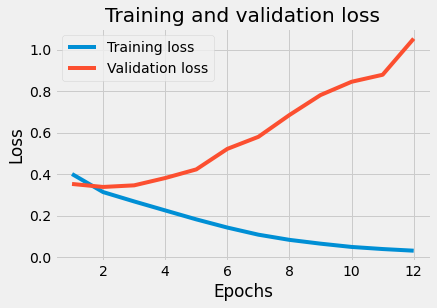

In [37]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs ,loss, label='Training loss')
plt.plot(epochs ,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 9) 모델 테스트

In [42]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1537/1537 [==============================] - 5s 4ms/step - loss: 0.3441 - acc: 0.8477

 테스트 정확도: 0.8477


# 2. Sentence Piece-BPE 로 토크나이즈 후 재시도

In [32]:
vocab_size = 8000

review_file = os.getenv('HOME')+'/mini_projects/_G-01_tokenize/movie_review.txt'

with open(review_file, 'w') as f:
    for row in train_data['document']: 
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=movie_review_bpe --vocab_size={} --model_type=bpe'.format(review_file, vocab_size)    
)
#위 Train에서  --model_type=unigram이 디폴트 적용되어 있습니다. --model_type =bpe 로 옵션을 주어 변경할 수 있습니다.

s = spm.SentencePieceProcessor()
s.Load('movie_review_bpe.model')

def sp_tokenize(s, train_corpus, test_corpus):

    train_tensor = []
    test_tensor = []

    for sen in train_corpus:
        train_tensor.append(s.EncodeAsIds(sen))
        
    for sen in test_corpus:
        test_tensor.append(s.EncodeAsIds(sen))

    with open("./movie_review.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return train_tensor, test_tensor, word_index, index_word

train_tensor, test_tensor, word_index, index_word = sp_tokenize(s, train_data['document'], test_data['document'])

훈련셋 문장의 최단 길이: 1
훈련셋 문장의 최장 길이: 130
훈련셋 문장의 평균 길이: 17


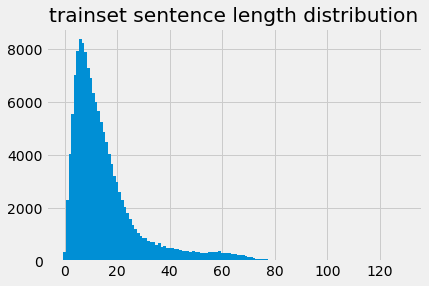

In [33]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("훈련셋 문장의 최단 길이:", min_len)
print("훈련셋 문장의 최장 길이:", max_len)
print("훈련셋 문장의 평균 길이:", sum_len // len(train_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("trainset sentence length distribution")
plt.show()

테스트셋 문장의 최단 길이: 1
테스트셋 문장의 최장 길이: 117
테스트셋 문장의 평균 길이: 16


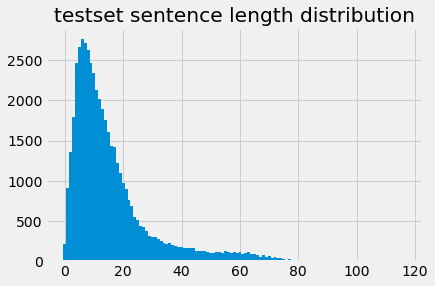

In [34]:
min_len = 999
max_len = 0
sum_len = 0

for sen in test_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("테스트셋 문장의 최단 길이:", min_len)
print("테스트셋 문장의 최장 길이:", max_len)
print("테스트셋 문장의 평균 길이:", sum_len // len(test_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in test_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("testset sentence length distribution")
plt.show()

In [35]:
maxlen = 20
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post', maxlen = maxlen)

In [38]:
Y_train = np.array(list(train_data['label']))
Y_test =  np.array(list(test_data['label']))

In [36]:
#  LSTM으로 학습
model = keras.Sequential([
    keras.layers.Embedding(8000, 100),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [39]:
history = model.fit(X_train, Y_train, epochs=100, callbacks=[early_stopping, model_checkpoint], 
                   batch_size=32 ,validation_split=0.2
                   )

Epoch 1/100
3655/3655 [==============================] - ETA: 0s - loss: 0.4000 - acc: 0.8172
Epoch 00001: val_acc improved from -inf to 0.84800, saving model to best_model.h5
3655/3655 [==============================] - 39s 11ms/step - loss: 0.4000 - acc: 0.8172 - val_loss: 0.3458 - val_acc: 0.8480
Epoch 2/100
3651/3655 [============================>.] - ETA: 0s - loss: 0.3127 - acc: 0.8638
Epoch 00002: val_acc improved from 0.84800 to 0.85607, saving model to best_model.h5
3655/3655 [==============================] - 38s 10ms/step - loss: 0.3127 - acc: 0.8638 - val_loss: 0.3317 - val_acc: 0.8561
Epoch 3/100
3653/3655 [============================>.] - ETA: 0s - loss: 0.2685 - acc: 0.8861
Epoch 00003: val_acc did not improve from 0.85607
3655/3655 [==============================] - 38s 10ms/step - loss: 0.2685 - acc: 0.8861 - val_loss: 0.3429 - val_acc: 0.8477
Epoch 4/100
3652/3655 [============================>.] - ETA: 0s - loss: 0.2235 - acc: 0.9083
Epoch 00004: val_acc did not imp

In [40]:
history_dict = history.history

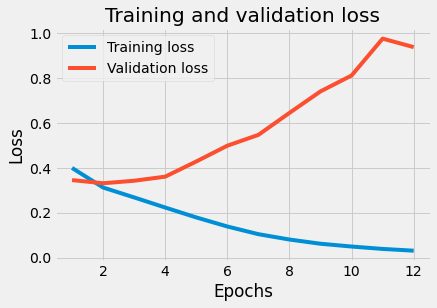

In [41]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs ,loss, label='Training loss')
plt.plot(epochs ,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [42]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1537/1537 [==============================] - 5s 4ms/step - loss: 0.3379 - acc: 0.8520

 테스트 정확도: 0.8520


## 결과 : Unigram보다 BPE에서 1% 더 향상, 별 차이 없음

# 3. Mecab 기반 토크나이즈 후 재시도

In [8]:
mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

train_mecab = []
test_mecab = []

for sen in train_data['document']:
    train_mecab.append(mecab_split(sen))
    
for sen in test_data['document']:
    test_mecab.append(mecab_split(sen))

In [9]:
train_mecab

[['아', '더', '빙', '.', '.', '진짜', '짜증', '나', '네요', '목소리'],
 ['흠',
  '.',
  '..',
  '포스터',
  '보고',
  '초딩',
  '영화',
  '줄',
  '.',
  '...',
  '오버',
  '연기',
  '조차',
  '가볍',
  '지',
  '않',
  '구나'],
 ['너무', '재', '밓었다그래서보는것을추천한다'],
 ['교도소',
  '이야기',
  '구먼',
  '.',
  '.',
  '솔직히',
  '재미',
  '는',
  '없',
  '다',
  '.',
  '.',
  '평점',
  '조정'],
 ['사이몬페그',
  '의',
  '익살',
  '스런',
  '연기',
  '가',
  '돋보였',
  '던',
  '영화',
  '!',
  '스파이더맨',
  '에서',
  '늙',
  '어',
  '보이',
  '기',
  '만',
  '했',
  '던',
  '커스틴',
  '던스트',
  '가',
  '너무나',
  '도',
  '이뻐',
  '보였',
  '다'],
 ['막',
  '걸음마',
  '뗀',
  '3',
  '세',
  '부터',
  '초등',
  '학교',
  '1',
  '학년',
  '생',
  '인',
  '8',
  '살',
  '용',
  '영화',
  '.',
  'ㅋㅋㅋ',
  '.',
  '..',
  '별반',
  '개',
  '도',
  '아까움',
  '.'],
 ['원작', '의', '긴장감', '을', '제대로', '살려', '내', '지', '못했', '다', '.'],
 ['별',
  '반개',
  '도',
  '아깝',
  '다',
  '욕',
  '나온다',
  '이응경',
  '길용우',
  '연기',
  '생활',
  '이',
  '몇',
  '년',
  '인지',
  '.',
  '.',
  '정말',
  '발',
  '로',
  '해도',
  '그것',
  '보단',
  '낫',
  '겟',
  '다',
  '

In [37]:
# def tokenize(train_mecab, test_mecab): 
#     train_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000)
#     train_tokenizer.fit_on_texts(train_mecab)   
#     train_tensor = train_tokenizer.texts_to_sequences(train_mecab) 
#     # tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

#     test_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000)
#     test_tokenizer.fit_on_texts(test_mecab)   
#     test_tensor = test_tokenizer.texts_to_sequences(test_mecab)

#     return train_tensor, test_tensor, train_tokenizer, test_tokenizer

# train_tensor, test_tensor, train_tokenizer, test_tokenizer = tokenize(train_mecab, test_mecab)

# len(train_tensor), len(test_tensor), len(train_tokenizer.word_index), len(test_tokenizer.word_index)

(146182, 49157, 53450, 32142)

# 의문   
## 1. 위에 토크나이즈 함수를 쓰면 왜 word-index vocab 크기가 8000이 안 되는 거지?   
## 2. 위에 토크나이즈 함수를 쓰면 왜 테스트 어큐러시가 50%대 밖에 안나오는 거지?   

In [12]:
words = np.concatenate(train_mecab).tolist()
counter = Counter(words)
counter = counter.most_common(7996)
vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
word_to_index = {word:index for index, word in enumerate(vocab)}

def wordlist_to_indexlist(wordlist):
    return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

train_tensor = list(map(wordlist_to_indexlist, train_mecab))
test_tensor = list(map(wordlist_to_indexlist, test_mecab))

len(train_tensor), len(test_tensor), len(word_to_index)

(146182, 49157, 8000)

# 위 코드가 그 위에 있는 토크나이즈 함수랑 뭐가 다른 거지?

훈련셋 문장의 최단 길이: 1
훈련셋 문장의 최장 길이: 116
훈련셋 문장의 평균 길이: 18


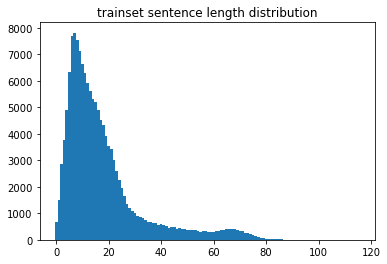

In [13]:
min_len = 999
max_len = 0
sum_len = 0

for sen in train_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("훈련셋 문장의 최단 길이:", min_len)
print("훈련셋 문장의 최장 길이:", max_len)
print("훈련셋 문장의 평균 길이:", sum_len // len(train_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in train_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("trainset sentence length distribution")
plt.show()

테스트셋 문장의 최단 길이: 1
테스트셋 문장의 최장 길이: 105
테스트셋 문장의 평균 길이: 18


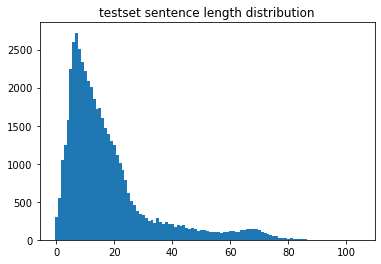

In [14]:
min_len = 999
max_len = 0
sum_len = 0

for sen in test_tensor:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("테스트셋 문장의 최단 길이:", min_len)
print("테스트셋 문장의 최장 길이:", max_len)
print("테스트셋 문장의 평균 길이:", sum_len // len(test_tensor))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in test_tensor:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("testset sentence length distribution")
plt.show()

In [15]:
maxlen = 30
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_tensor, padding='post', maxlen = maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_tensor, padding='post', maxlen = maxlen)

In [16]:
Y_train = np.array(list(train_data['label']))
Y_test =  np.array(list(test_data['label']))

In [17]:
#  LSTM으로 학습
model = keras.Sequential([
    keras.layers.Embedding(8000, 100), # (Size of the vocabulary, Dimension of the dense embedding)
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(128),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [18]:
history = model.fit(X_train, Y_train, epochs=100, callbacks=[early_stopping, model_checkpoint], 
                   batch_size=32 ,validation_split=0.2
                   )

Epoch 1/100
3653/3655 [============================>.] - ETA: 0s - loss: 0.3829 - acc: 0.8278
Epoch 00001: val_acc improved from -inf to 0.85720, saving model to best_model.h5
3655/3655 [==============================] - 41s 11ms/step - loss: 0.3830 - acc: 0.8278 - val_loss: 0.3320 - val_acc: 0.8572
Epoch 2/100
3653/3655 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.8718
Epoch 00002: val_acc improved from 0.85720 to 0.86237, saving model to best_model.h5
3655/3655 [==============================] - 41s 11ms/step - loss: 0.3013 - acc: 0.8718 - val_loss: 0.3212 - val_acc: 0.8624
Epoch 3/100
3652/3655 [============================>.] - ETA: 0s - loss: 0.2627 - acc: 0.8908
Epoch 00003: val_acc did not improve from 0.86237
3655/3655 [==============================] - 41s 11ms/step - loss: 0.2627 - acc: 0.8907 - val_loss: 0.3269 - val_acc: 0.8616
Epoch 4/100
3653/3655 [============================>.] - ETA: 0s - loss: 0.2296 - acc: 0.9057
Epoch 00004: val_acc improved fr

In [19]:
history_dict = history.history

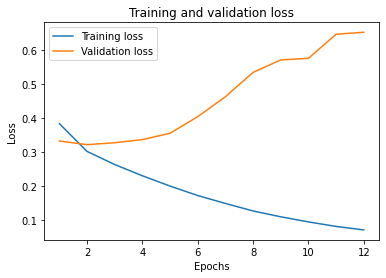

In [20]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs ,loss, label='Training loss')
plt.plot(epochs ,val_loss,label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, Y_test)[1]))

1537/1537 [==============================] - 6s 4ms/step - loss: 0.3383 - acc: 0.8586

 테스트 정확도: 0.8586


# 결과   
### mecab이 SP보다 1% + a 정도 수준 더 좋다

# 회고   
### 1. SP 토크나이즈만 하고 문장길이는 원래 상태 그대로 둔 후 모델에 돌렸을 때 훈련이 되지 않았다. 왜?   
   
   
### 2. SP 토크나이즈를 하고 다른 토큰 추가 없이 0 패딩 처리만 했는데 모델이 돌아간다. 왜?   
   
   
### 3. 모든 문장을 다 쓰는 대신, 각 문장 길이를 20으로 통일하고 쓰는 건 쉬운데 데이터를 일정 길이 이하, 이상인 문장만 쓰려면, 레이블도 똑같이 날려줘야 한다. 어떻게 해야 되지? 날아가는 경계점을 찾아야 되나?   
   
   
### 4. mecab 토크나이즈 함수를 토크나이즈 시 train_tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=8000) 이렇게 해 주면 word_index vocab 사이즈가 800이 안 된다. 대신 모델 훈련은 되는데 test accuracy가 56% 밖에 안 나온다. 왜지? 


### keras.layers.Embedding(8000, 100), 케라스에서 임베딩 레이어를 만들 때 Size of the vocabulary, Dimension of the dense embedding 를 정해줘야 한다.